In [1]:

!pip install streamlit tensorflow pandas scikit-learn langdetect unidecode wordcloud imblearn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 26.6 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 96.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 94.3 MB/s eta 0:00:00:00:01
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=06c2db682f953f6c5a314d580f7588623fb9f5be1bf2a227fa60b9b80ae7cfa8
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split  # Import train_test_split
from sklearn.metrics import classification_report

In [3]:
import pandas as pd

sight_df = pd.read_csv(
    "https://raw.githubusercontent.com/Sriva29/bert-learning-analytics/refs/heads/main/data/reviews_by_course.csv",
    delimiter=",",               # Specify delimiter
    quotechar='"',               # Handle embedded quotes
    escapechar="\\",             # Escape special characters
    on_bad_lines="skip",         # Skip problematic lines
    engine="python"              # Use the Python parser for flexibility
)

# Upon analysis, we discovered that this dataset can be used to test since it is unlabelled.
#sight_df.head()

coursera_df = pd.read_csv("https://raw.githubusercontent.com/Sriva29/bert-learning-analytics/refs/heads/main/data/reviews_by_course.csv")
coursera_df.head()

,CourseId,Review,Label
0,2-speed-it,BOring,1
1,2-speed-it,Bravo !,5
2,2-speed-it,Very goo,5
3,2-speed-it,"Great course - I recommend it for all, especia...",5
4,2-speed-it,One of the most useful course on IT Management!,5


In [4]:
#Inspecting the data types and checking if there are any missing values
print(coursera_df.info())
print(coursera_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140320 entries, 0 to 140319
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   CourseId  140320 non-null  object
 1   Review    140317 non-null  object
 2   Label     140320 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 3.2+ MB
None
CourseId    0
Review      3
Label       0
dtype: int64


In [5]:
# Since only 3 missing values, dropping them
coursera_df = coursera_df.dropna(subset=["Review"])
print(coursera_df.isnull().sum())

CourseId    0
Review      0
Label       0
dtype: int64


In [6]:
#Checking label distribution
print(coursera_df["Label"].value_counts())

Label
5    106514
4     22460
3      5923
1      2866
2      2554
Name: count, dtype: int64


In [7]:
# '''At this point, given that the dataset is skewed with a lot more rows labelled 5 than not, given the choice of undersampling label 5, oversampling the lower labels 1-4,
# and using class weights, we decided to go with class weights to avoid artificially adding data (fake reviews) to the dataset.
# '''

# from sklearn.utils.class_weight import compute_class_weight
# import numpy as np

# #Defining the classes and their freq

# classes = sorted(coursera_df["Label"].unique())
# print(classes)

# # Converting the list of classes to a numpy array
# classes = np.array(classes)

# class_weights = compute_class_weight(
#     class_weight = "balanced",
#     classes = classes,
#     y=coursera_df["Label"]
# )

# #Converting to dictionary for easy ref
# class_weights_dict = {classes[i]: class_weights[i] for i in range(len(classes))}
# print(class_weights_dict)



In [8]:

from langdetect import  detect
from langdetect.lang_detect_exception import LangDetectException
def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return "unknown"

#Detecting each review language
coursera_df["Language"] = coursera_df["Review"].apply(detect_language)

#filtering only English reviews
english_reviews_df = coursera_df[coursera_df["Language"]=="en"]

print(english_reviews_df["Language"].value_counts())
english_reviews_df.head()

Language
en    106875
Name: count, dtype: int64


,CourseId,Review,Label,Language
3,2-speed-it,"Great course - I recommend it for all, especia...",5,en
4,2-speed-it,One of the most useful course on IT Management!,5,en
5,2-speed-it,I was disappointed because the name is mislead...,3,en
6,2-speed-it,Super content. I'll definitely re-do the course,5,en
8,2-speed-it,One of the excellent courses at Coursera for i...,5,en


In [9]:
#Fixing giberrish

from unidecode import unidecode

english_reviews_df["cleaned_review"] = english_reviews_df["Review"].apply(unidecode)

print(english_reviews_df["cleaned_review"].head())
print(english_reviews_df["Label"])
print(english_reviews_df.shape)


3    Great course - I recommend it for all, especia...
4      One of the most useful course on IT Management!
5    I was disappointed because the name is mislead...
6      Super content. I'll definitely re-do the course
8    One of the excellent courses at Coursera for i...
Name: cleaned_review, dtype: object
3         5
4         5
5         3
6         5
8         5
         ..
140315    4
140316    5
140317    5
140318    4
140319    4
Name: Label, Length: 106875, dtype: int64
(106875, 5)


<ipython-input-9-0fc02ddb4e33>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_reviews_df["cleaned_review"] = english_reviews_df["Review"].apply(unidecode)


In [10]:
print(english_reviews_df.head())

     CourseId                                             Review  Label  \
3  2-speed-it  Great course - I recommend it for all, especia...      5   
4  2-speed-it    One of the most useful course on IT Management!      5   
5  2-speed-it  I was disappointed because the name is mislead...      3   
6  2-speed-it    Super content. I'll definitely re-do the course      5   
8  2-speed-it  One of the excellent courses at Coursera for i...      5   

  Language                                     cleaned_review  
3       en  Great course - I recommend it for all, especia...  
4       en    One of the most useful course on IT Management!  
5       en  I was disappointed because the name is mislead...  
6       en    Super content. I'll definitely re-do the course  
8       en  One of the excellent courses at Coursera for i...  


In [11]:
#Checking whether original df had more langs

print(coursera_df["Language"].value_counts())



Language
en         106875
es          12282
fr           3591
zh-cn        2325
pt           2254
ro           2094
ca           1992
ru           1534
af           1521
so            989
de            772
it            537
no            415
ko            336
tl            326
cy            273
sw            255
id            212
unknown       206
nl            189
vi            181
pl            167
sl            151
da            146
cs             83
et             80
sk             79
sq             71
tr             54
zh-tw          48
sv             45
fi             41
hr             35
hu             34
bg             30
lt             28
mk             14
uk             13
he             11
ar             10
lv             10
fa              4
ja              2
ur              1
el              1
Name: count, dtype: int64


In [12]:
import re

# Text cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Applying cleaning to the Review column
english_reviews_df["cleaned_review"] = english_reviews_df["Review"].apply(clean_text)

# Verifying the changes
print(english_reviews_df[["Review", "cleaned_review"]].head())

                                              Review  \
3  Great course - I recommend it for all, especia...   
4    One of the most useful course on IT Management!   
5  I was disappointed because the name is mislead...   
6    Super content. I'll definitely re-do the course   
8  One of the excellent courses at Coursera for i...   

                                      cleaned_review  
3  great course i recommend it for all especially...  
4     one of the most useful course on it management  
5  i was disappointed because the name is mislead...  
6       super content ill definitely redo the course  
8  one of the excellent courses at coursera for i...  


<ipython-input-12-cb3b9402fbce>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_reviews_df["cleaned_review"] = english_reviews_df["Review"].apply(clean_text)


In [13]:
# !pip install wordcloud

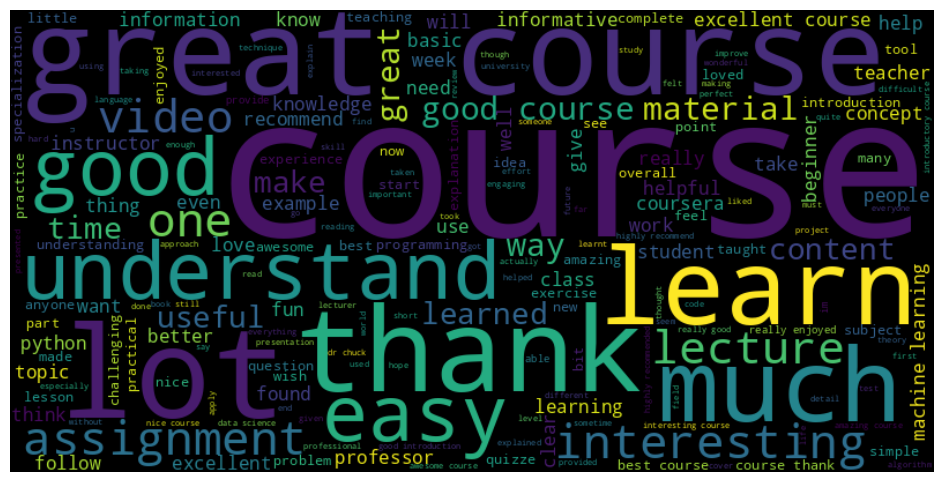

In [14]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
text = ' '.join(english_reviews_df['cleaned_review'])
wordcloud = WordCloud(width=800, height=400).generate(text)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [15]:
print(english_reviews_df['Label'])

3         5
4         5
5         3
6         5
8         5
         ..
140315    4
140316    5
140317    5
140318    4
140319    4
Name: Label, Length: 106875, dtype: int64


In [16]:
# splitting the labels in 3 parts , so we can use sparse_categorical_crossentropy loss function while training the model.
def map_sentiment(Label):
    if Label <= 2:
        return 'Negative'
    elif Label == 3:
        return 'Neutral'
    else:
        return 'Positive'

english_reviews_df['Sentiment'] = english_reviews_df['Label'].apply(map_sentiment)
print(english_reviews_df['Sentiment'].value_counts())

Sentiment
Positive    97098
Neutral      5067
Negative     4710
Name: count, dtype: int64


<ipython-input-16-bbbf7cdd1b69>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_reviews_df['Sentiment'] = english_reviews_df['Label'].apply(map_sentiment)


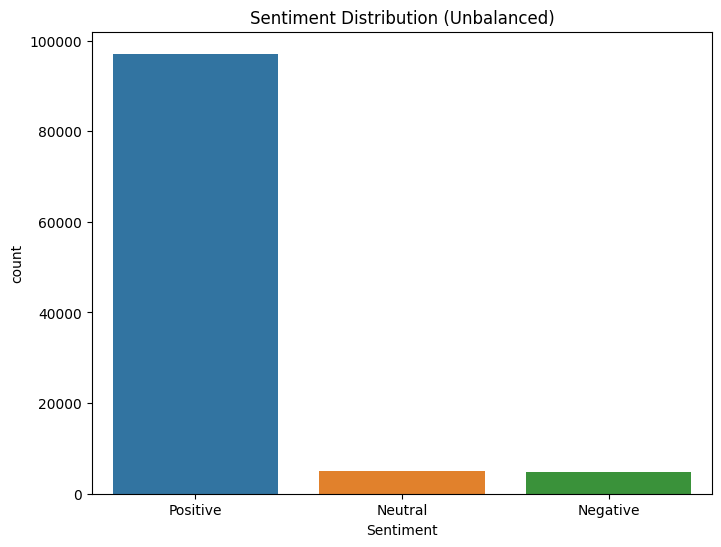

In [17]:
import seaborn as sns

# Visualizing label distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=english_reviews_df['Sentiment'])
plt.title('Sentiment Distribution (Unbalanced)')
plt.show()

In [18]:
# split the dataset to train with logistic regression model.
from sklearn.model_selection import train_test_split

X = english_reviews_df['cleaned_review']
y = english_reviews_df['Sentiment']
print(X.head(),y.head())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

3    great course i recommend it for all especially...
4       one of the most useful course on it management
5    i was disappointed because the name is mislead...
6         super content ill definitely redo the course
8    one of the excellent courses at coursera for i...
Name: cleaned_review, dtype: object 3    Positive
4    Positive
5     Neutral
6    Positive
8    Positive
Name: Sentiment, dtype: object


In [19]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

log_model = LogisticRegression()
log_model.fit(X_train_tfidf, y_train)
y_pred_log = log_model.predict(X_test_tfidf)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [22]:

print("Accuracy (Logistic Regression):", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))
# Acc_log_reg=accuracy_score(y_test, y_pred)
# Classf_log_reg=classification_report(y_test, y_pred)

Accuracy (Logistic Regression): 0.927859649122807
              precision    recall  f1-score   support

           0       0.68      0.48      0.56       901
           1       0.42      0.12      0.19      1003
           2       0.94      0.99      0.97     19471

    accuracy                           0.93     21375
   macro avg       0.68      0.53      0.57     21375
weighted avg       0.91      0.93      0.91     21375



In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping


tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=100)
X_test_pad = pad_sequences(X_test_seq, maxlen=100)

unbal_lstm = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    LSTM(128, dropout=0.5, recurrent_dropout=0.5),
    Dense(3, activation='softmax')
])

unbal_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_unbalanced_lstm=unbal_lstm.fit(X_train_pad, y_train, epochs=10, batch_size=64, validation_data=(X_test_pad, y_test), callbacks=[early_stopping])





/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 188s 136ms/step - accuracy: 0.9038 - loss: 0.3289 - val_accuracy: 0.9218 - val_loss: 0.2208
Epoch 2/10
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 183s 137ms/step - accuracy: 0.9237 - loss: 0.2132 - val_accuracy: 0.9273 - val_loss: 0.2012
Epoch 3/10
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 181s 135ms/step - accuracy: 0.9313 - loss: 0.1855 - val_accuracy: 0.9306 - val_loss: 0.1948
Epoch 4/10
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 182s 136ms/step - accuracy: 0.9353 - loss: 0.1740 - val_accuracy: 0.9289 - val_loss: 0.1964
Epoch 5/10
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 182s 137ms/step - accuracy: 0.9420 - loss: 0.1551 - val_accuracy: 0.9286 - val_loss: 0.1996
Epoch 6/10
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 182s 136ms/step - accuracy: 0.9466 - loss: 0.1463 - val_accuracy: 0.9251 - val_loss: 0.2048


In [24]:
import numpy as np
y_pred_unbal_lstm = unbal_lstm.predict(X_test_pad)
y_pred_unbal_lstm = np.argmax(y_pred_unbal_lstm, axis=1)

print("Accuracy (Unbalanced LSTM):", accuracy_score(y_test, y_pred_unbal_lstm))
print(classification_report(y_test, y_pred_unbal_lstm))

668/668 ━━━━━━━━━━━━━━━━━━━━ 26s 38ms/step
Accuracy (Unbalanced LSTM): 0.9306198830409357
              precision    recall  f1-score   support

           0       0.62      0.59      0.61       901
           1       0.41      0.11      0.17      1003
           2       0.95      0.99      0.97     19471

    accuracy                           0.93     21375
   macro avg       0.66      0.56      0.58     21375
weighted avg       0.91      0.93      0.92     21375



# Balancing the dataset and retrain model

In [25]:
# !pip install -q imblearn
from collections import Counter
from imblearn.over_sampling import RandomOverSampler


In [26]:

# Combine features and labels for resampling
X_resample = X_train
y_resample = y_train

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(pd.DataFrame(X_resample), y_resample)

print('Original dataset shape:', Counter(y_train))
print('Resampled dataset shape:', Counter(y_resampled))

Original dataset shape: Counter({2: 77627, 1: 4064, 0: 3809})
Resampled dataset shape: Counter({2: 77627, 0: 77627, 1: 77627})


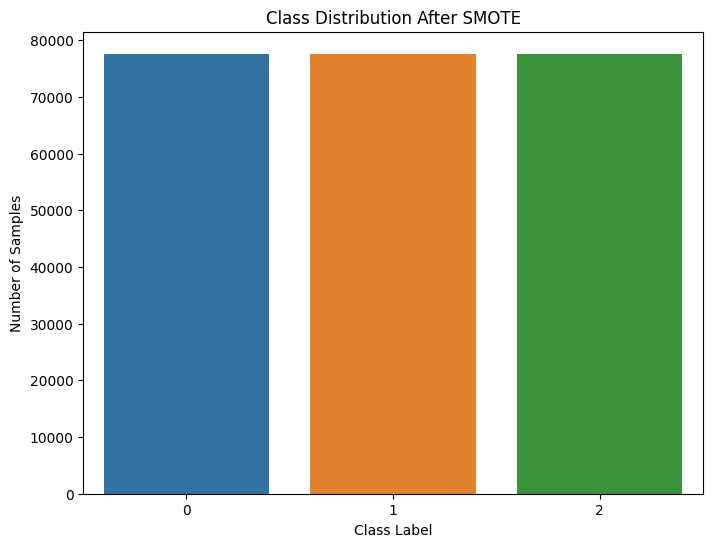

In [27]:
plt.figure(figsize=(8, 6))  # Adjust figure size if needed
sns.countplot(x=y_resampled)
plt.title('Class Distribution After SMOTE')
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.show()

In [28]:
# Ensure X_resampled is treated as a series of text data
X_resampled_text = X_resampled.iloc[:, 0] if isinstance(X_resampled, pd.DataFrame) else X_resampled

# Re-fit the TF-IDF vectorizer with the resampled data
tfidf_resampled = TfidfVectorizer(max_features=5000)
X_resampled_tfidf = tfidf_resampled.fit_transform(X_resampled_text)

# Transform the test set using the new vectorizer
X_test_tfidf = tfidf_resampled.transform(X_test)

In [29]:
# Retrain Logistic Regression
log_model_balanced = LogisticRegression(max_iter=1000)
log_model_balanced.fit(X_resampled_tfidf, y_resampled)
y_pred_log_balanced = log_model_balanced.predict(X_test_tfidf)

print("Accuracy (Logistic Regression with Balanced Data):", accuracy_score(y_test, y_pred_log_balanced))
print(classification_report(y_test, y_pred_log_balanced))


Accuracy (Logistic Regression with Balanced Data): 0.8349941520467836
              precision    recall  f1-score   support

           0       0.38      0.65      0.48       901
           1       0.19      0.54      0.28      1003
           2       0.99      0.86      0.92     19471

    accuracy                           0.83     21375
   macro avg       0.52      0.68      0.56     21375
weighted avg       0.92      0.83      0.87     21375



# Retraining LSTM model on balanced dataset

In [30]:
# Ensure X_resampled is treated as a series of text data
X_resampled_text = X_resampled.iloc[:, 0] if isinstance(X_resampled, pd.DataFrame) else X_resampled

# Tokenize and pad the resampled data
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_resampled_text)

X_resampled_seq = tokenizer.texts_to_sequences(X_resampled_text)
X_resampled_pad = pad_sequences(X_resampled_seq, maxlen=100)

# Tokenize and pad the test set
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, maxlen=100)

In [31]:
from tensorflow.keras.regularizers import l2

balanced_lstm = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    LSTM(128, dropout=0.5, recurrent_dropout=0.5, return_sequences=True),
    LSTM(64, dropout=0.5, recurrent_dropout=0.5),
    Dense(3, activation='softmax')
])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

balanced_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [32]:
history_balanced_lstm = balanced_lstm.fit(
    X_resampled_pad, y_resampled,
    epochs=10,
    batch_size=64,
    validation_data=(X_test_pad, y_test),
    callbacks=[early_stopping]
)


Epoch 1/10
3639/3639 ━━━━━━━━━━━━━━━━━━━━ 949s 260ms/step - accuracy: 0.7032 - loss: 0.6557 - val_accuracy: 0.8546 - val_loss: 0.4036
Epoch 2/10
3639/3639 ━━━━━━━━━━━━━━━━━━━━ 941s 259ms/step - accuracy: 0.8861 - loss: 0.3123 - val_accuracy: 0.8521 - val_loss: 0.4493
Epoch 3/10
3639/3639 ━━━━━━━━━━━━━━━━━━━━ 941s 259ms/step - accuracy: 0.9190 - loss: 0.2278 - val_accuracy: 0.8606 - val_loss: 0.4676
Epoch 4/10
3639/3639 ━━━━━━━━━━━━━━━━━━━━ 953s 262ms/step - accuracy: 0.9348 - loss: 0.1845 - val_accuracy: 0.8691 - val_loss: 0.4984


In [33]:
y_pred_balanced_lstm = balanced_lstm.predict(X_test_pad)
y_pred_balanced_lstm = np.argmax(y_pred_balanced_lstm, axis=1)

print("Accuracy (Balanced LSTM):", accuracy_score(y_test, y_pred_balanced_lstm))
print(classification_report(y_test, y_pred_balanced_lstm))


668/668 ━━━━━━━━━━━━━━━━━━━━ 40s 60ms/step
Accuracy (Balanced LSTM): 0.8545964912280701
              precision    recall  f1-score   support

           0       0.41      0.59      0.48       901
           1       0.21      0.54      0.30      1003
           2       0.99      0.88      0.93     19471

    accuracy                           0.85     21375
   macro avg       0.53      0.67      0.57     21375
weighted avg       0.92      0.85      0.88     21375



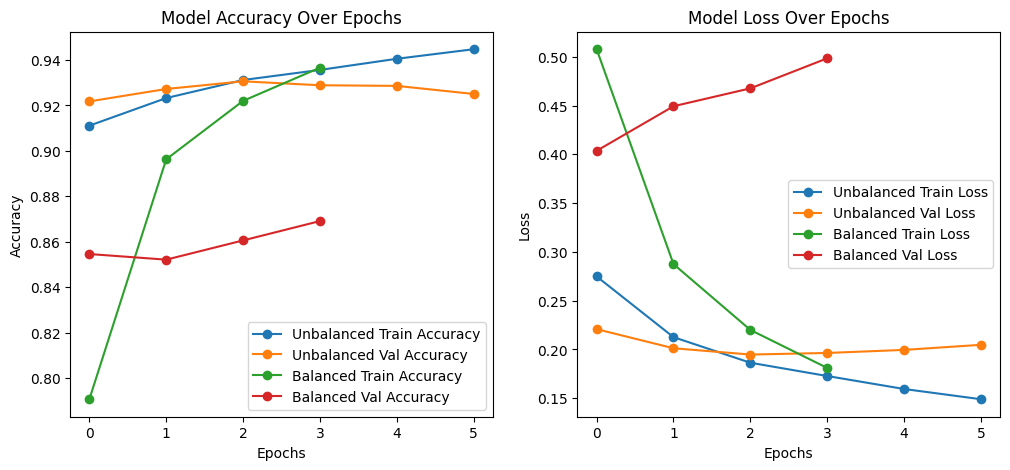

In [34]:

# Extract loss and accuracy from history
history_unbalanced_dict = history_unbalanced_lstm.history
history_balanced_dict = history_balanced_lstm.history

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_unbalanced_dict['accuracy'], label='Unbalanced Train Accuracy', marker='o')
plt.plot(history_unbalanced_dict['val_accuracy'], label='Unbalanced Val Accuracy', marker='o')
plt.plot(history_balanced_dict['accuracy'], label='Balanced Train Accuracy', marker='o')
plt.plot(history_balanced_dict['val_accuracy'], label='Balanced Val Accuracy', marker='o')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_unbalanced_dict['loss'], label='Unbalanced Train Loss', marker='o')
plt.plot(history_unbalanced_dict['val_loss'], label='Unbalanced Val Loss', marker='o')
plt.plot(history_balanced_dict['loss'], label='Balanced Train Loss', marker='o')
plt.plot(history_balanced_dict['val_loss'], label='Balanced Val Loss', marker='o')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Observations:
Unbalanced Train Accuracy (Blue Line): Starts around 91% and steadily improves to 94%.
Unbalanced Validation Accuracy (Orange Line): Starts slightly higher and remains stable around 92%, with a slight drop at the end.
Balanced Train Accuracy (Green Line): Starts lower (~80%) but rapidly increases, catching up with the unbalanced model.
Balanced Validation Accuracy (Red Line): Gradually improves but remains slightly below the unbalanced validation accuracy.
### The balanced model starts off weaker but quickly catches up, indicating better generalization.
### The unbalanced model performs consistently well on validation, but this could mean it's overfitting to specific patterns in the dataset.


Observations:
Unbalanced Train Loss (Blue Line): Decreases steadily, which is expected.
Unbalanced Validation Loss (Orange Line): Decreases initially but starts increasing slightly, indicating possible overfitting.
Balanced Train Loss (Green Line): Starts high (~0.5) but drops significantly, showing the model is learning fast.
Balanced Validation Loss (Red Line): Increases, which might indicate underfitting or noisy validation data.
### conclusion The balanced model learns significantly in early epochs but still struggles with validation performance.
### The unbalanced model has lower validation loss, but its increasing trend suggests it might overfit.

#  Now lets try with LSTM model by finetuning it.

In [35]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.model_selection import train_test_split
# from sklearn.utils.class_weight import compute_class_weight
# from sklearn.metrics import classification_report, accuracy_score
# from imblearn.over_sampling import SMOTE
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
# from tensorflow.keras.callbacks import EarlyStopping

In [36]:
english_reviews_fLstm_df = english_reviews_df.copy()


In [37]:
# Binary classification: 0 (negative), 1 (positive)
english_reviews_fLstm_df.loc[english_reviews_fLstm_df['Label'] <= 3, 'Label'] = 0
english_reviews_fLstm_df.loc[english_reviews_fLstm_df['Label'] > 3, 'Label'] = 1


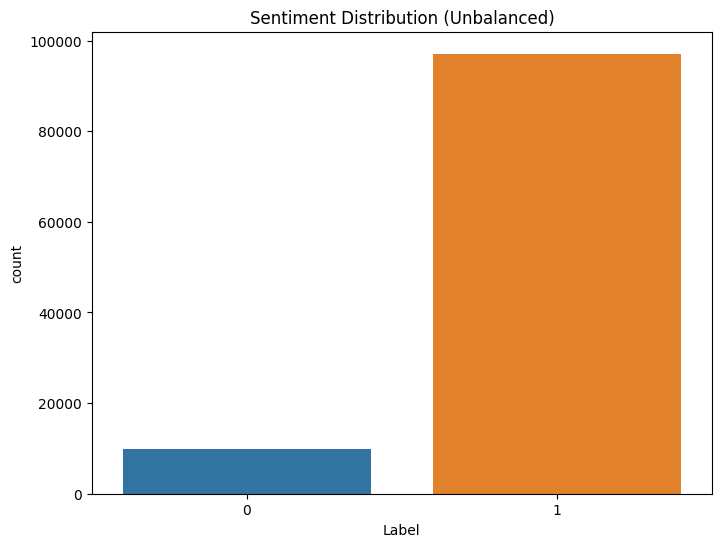

In [38]:
import seaborn as sns

# Visualizing label distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=english_reviews_fLstm_df['Label'])
plt.title('Sentiment Distribution (Unbalanced)')
plt.show()

In [39]:
print(english_reviews_fLstm_df['Label'].value_counts())

Label
1    97098
0     9777
Name: count, dtype: int64


In [43]:
# Tokenize the text
max_words = 20000  # Vocabulary size
max_len = 100  # Max length of sequences
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(english_reviews_fLstm_df['cleaned_review'])

sequences = tokenizer.texts_to_sequences(english_reviews_fLstm_df['cleaned_review'])
X = pad_sequences(sequences, maxlen=max_len)
y = english_reviews_fLstm_df['Label'].values

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [46]:

# Compute class weights
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Build LSTM model for unbalanced data
unbalanced_lstm_model = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

unbalanced_lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# unbalanced_lstm_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [47]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model on unbalanced data
history_unbalanced_ft = unbalanced_lstm_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=64,
    verbose=1,
    class_weight=class_weights_dict,
    callbacks=[early_stopping]
)

Epoch 1/10
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 44s 29ms/step - accuracy: 0.7948 - loss: 0.4582 - val_accuracy: 0.8611 - val_loss: 0.3133
Epoch 2/10
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 38s 29ms/step - accuracy: 0.8884 - loss: 0.2580 - val_accuracy: 0.8820 - val_loss: 0.2802
Epoch 3/10
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 39s 29ms/step - accuracy: 0.9209 - loss: 0.2010 - val_accuracy: 0.9148 - val_loss: 0.2042
Epoch 4/10
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 38s 29ms/step - accuracy: 0.9386 - loss: 0.1622 - val_accuracy: 0.9104 - val_loss: 0.2412
Epoch 5/10
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 39s 29ms/step - accuracy: 0.9443 - loss: 0.1449 - val_accuracy: 0.8991 - val_loss: 0.2990
Epoch 6/10
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 38s 29ms/step - accuracy: 0.9546 - loss: 0.1186 - val_accuracy: 0.8880 - val_loss: 0.3441


In [48]:
# Evaluate the model on test set
loss, accuracy = unbalanced_lstm_model.evaluate(X_test, y_test, verbose=1)
print(f"Unbalanced Model Test Accuracy: {accuracy * 100:.2f}%")

# Predictions for unbalanced model
y_pred_unbalanced = (unbalanced_lstm_model.predict(X_test) > 0.5).astype("int32")
print("\nUnbalanced Model Classification Report:")
print(classification_report(y_test, y_pred_unbalanced))

668/668 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9157 - loss: 0.2046
Unbalanced Model Test Accuracy: 91.48%
668/668 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step

Unbalanced Model Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.82      0.64      1955
           1       0.98      0.92      0.95     19420

    accuracy                           0.91     21375
   macro avg       0.75      0.87      0.80     21375
weighted avg       0.94      0.91      0.92     21375



In [49]:
# import matplotlib.pyplot as plt

# # Extract loss and accuracy from history
# history_dict_unbal = history_unbalanced.history

# print("Available keys in history:", history_dict.keys())

# # Plot training & validation accuracy
# plt.figure(figsize=(12, 5))

# # Accuracy Plot
# plt.subplot(1, 2, 1)
# plt.plot(history_dict_unbal['accuracy'], label='Train Accuracy', marker='o')
# plt.plot(history_dict_unbal['val_accuracy'], label='Validation Accuracy', marker='o')
# plt.title('Model Accuracy Over Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

# # Loss Plot
# plt.subplot(1, 2, 2)
# plt.plot(history_dict_unbal['loss'], label='Train Loss', marker='o')
# plt.plot(history_dict_unbal['val_loss'], label='Validation Loss', marker='o')
# plt.title('Model Loss Over Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# # Show the plots
# plt.show()


# ---------------------------- BALANCED LSTM MODEL -----------------------



In [51]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [54]:
# Compute class weights for balanced dataset
class_weights_balanced = compute_class_weight(class_weight="balanced", classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weights_dict_balanced = {i: class_weights_balanced[i] for i in range(len(class_weights_balanced))}

# Build LSTM model for balanced data
balanced_lstm_model = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

balanced_lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# balanced_lstm_model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [53]:
# Train the model on balanced data
history_balanced_ft = balanced_lstm_model.fit(
    X_train_resampled, y_train_resampled,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=64,
    verbose=1,
    class_weight=class_weights_dict_balanced,
    callbacks=[early_stopping]
)

# Evaluate the balanced model on test set
loss_balanced, accuracy_balanced = balanced_lstm_model.evaluate(X_test, y_test, verbose=1)
print(f"Balanced Model Test Accuracy: {accuracy_balanced * 100:.2f}%")

# Predictions for balanced model
y_pred_balanced = (balanced_lstm_model.predict(X_test) > 0.5).astype("int32")
print("\nBalanced Model Classification Report:")
print(classification_report(y_test, y_pred_balanced))


Epoch 1/10
2428/2428 ━━━━━━━━━━━━━━━━━━━━ 72s 28ms/step - accuracy: 0.8263 - loss: 0.3743 - val_accuracy: 0.9283 - val_loss: 0.1906
Epoch 2/10
2428/2428 ━━━━━━━━━━━━━━━━━━━━ 68s 28ms/step - accuracy: 0.9530 - loss: 0.1223 - val_accuracy: 0.9252 - val_loss: 0.1892
Epoch 3/10
2428/2428 ━━━━━━━━━━━━━━━━━━━━ 67s 28ms/step - accuracy: 0.9682 - loss: 0.0866 - val_accuracy: 0.9284 - val_loss: 0.1848
Epoch 4/10
2428/2428 ━━━━━━━━━━━━━━━━━━━━ 67s 28ms/step - accuracy: 0.9755 - loss: 0.0665 - val_accuracy: 0.9284 - val_loss: 0.2013
Epoch 5/10
2428/2428 ━━━━━━━━━━━━━━━━━━━━ 68s 28ms/step - accuracy: 0.9819 - loss: 0.0513 - val_accuracy: 0.9137 - val_loss: 0.2702
Epoch 6/10
2428/2428 ━━━━━━━━━━━━━━━━━━━━ 68s 28ms/step - accuracy: 0.9853 - loss: 0.0427 - val_accuracy: 0.9213 - val_loss: 0.2749
668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9282 - loss: 0.1861
Balanced Model Test Accuracy: 92.84%
668/668 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step

Balanced Model Classification Report:
              p

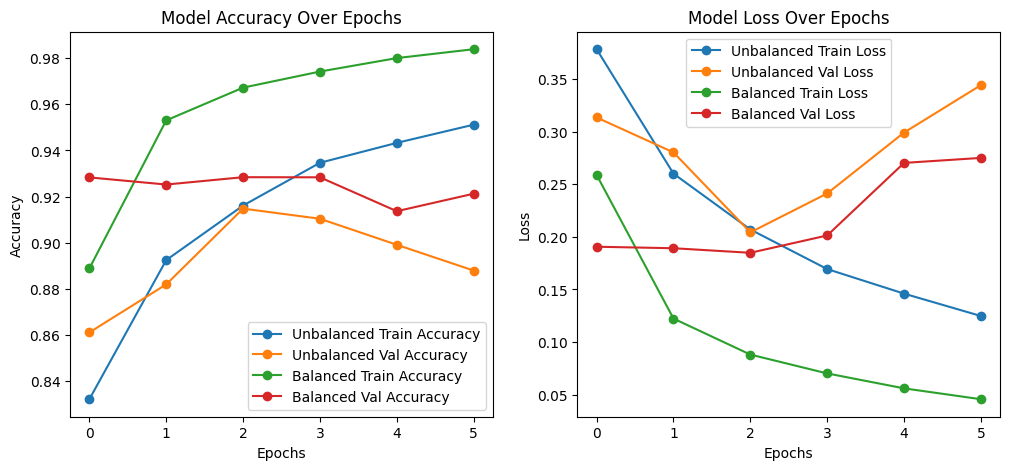

In [55]:

# Extract loss and accuracy from history
history_unbalanced_ft_dict = history_unbalanced_ft.history
history_balanced_ft_dict = history_balanced_ft.history

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_unbalanced_ft_dict['accuracy'], label='Unbalanced Train Accuracy', marker='o')
plt.plot(history_unbalanced_ft_dict['val_accuracy'], label='Unbalanced Val Accuracy', marker='o')
plt.plot(history_balanced_ft_dict['accuracy'], label='Balanced Train Accuracy', marker='o')
plt.plot(history_balanced_ft_dict['val_accuracy'], label='Balanced Val Accuracy', marker='o')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_unbalanced_ft_dict['loss'], label='Unbalanced Train Loss', marker='o')
plt.plot(history_unbalanced_ft_dict['val_loss'], label='Unbalanced Val Loss', marker='o')
plt.plot(history_balanced_ft_dict['loss'], label='Balanced Train Loss', marker='o')
plt.plot(history_balanced_ft_dict['val_loss'], label='Balanced Val Loss', marker='o')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


Unbalanced Train Loss (Blue Line): Decreases steadily, showing the model learns.
Unbalanced Validation Loss (Orange Line): Decreases at first, but then increases, indicating overfitting.
Balanced Train Loss (Green Line): Starts low and decreases further, meaning the model learns effectively.
Balanced Validation Loss (Red Line): Remains mostly stable but slightly increases.

### Balancing the dataset significantly improves model performance.

The "Balanced" lines (green and red) consistently outperform the "Unbalanced" lines (blue and orange) in both accuracy and loss. This indicates that balancing the dataset helps the model learn more effectively and generalize better to unseen data.
Unbalanced data leads to overfitting.

### The "Unbalanced" model exhibits signs of overfitting. 
The training accuracy increases steadily, while the validation accuracy plateaus or even decreases. This suggests that the model is memorizing the training data rather than learning generalizable patterns.
Balanced data improves generalization.

### The "Balanced" model shows a more consistent improvement in both training and validation accuracy. 
The validation accuracy remains close to the training accuracy, indicating that the model is learning generalizable patterns and not overfitting.